In [2]:
#Referencing https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb
import yfinance as yf
import pandas_datareader as pdr
import datetime

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

### $Price_t = PriceToSales_tSalesPerShare_t$

In [3]:
df_sp500_uncleaned = yf.Ticker("^GSPC").history(period='max')

In [8]:
def clean_df(df):
    SP500_Sales_Per_Share = pd.read_csv('data/S&P 500 Sales Per Share.csv')
    SP500_Sales_Per_Share.index = pd.to_datetime(SP500_Sales_Per_Share['Date\tSales Per Share'].str[:10], format='%m/%d/%Y')
    SP500_Sales_Per_Share.index.name = None
    SP500_Sales_Per_Share = SP500_Sales_Per_Share.rename(columns={'Date\tSales Per Share': 'Sales Per Share'})
    SP500_Sales_Per_Share['Sales Per Share'] = SP500_Sales_Per_Share['Sales Per Share'].str[11:].astype('float')
    SP500_Sales_Per_Share = SP500_Sales_Per_Share.sort_index()
    SP500_Sales_Per_Share = SP500_Sales_Per_Share.reindex(pd.date_range(SP500_Sales_Per_Share.index[0], SP500_Sales_Per_Share.index[-1], freq='D')).interpolate()

    df.index.name = None
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.reindex(pd.date_range(df.index[0], df.index[-1], freq='D')).interpolate()
    #df['Return'] = df['Close'] / df['Open']
    df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
    df = df.rename(columns={'Close': 'Price'})

    df = pd.merge(df, SP500_Sales_Per_Share, how='inner', left_index=True, right_index=True)
    df['Price to Sales'] = df['Price'] / df['Sales Per Share']
    df['Return'] = df['Price'] / df['Price'].shift(1)
    df['Change'] = df['Price'] - df['Price'].shift(1)

    return df.dropna()
df_sp500 = clean_df(df_sp500_uncleaned)

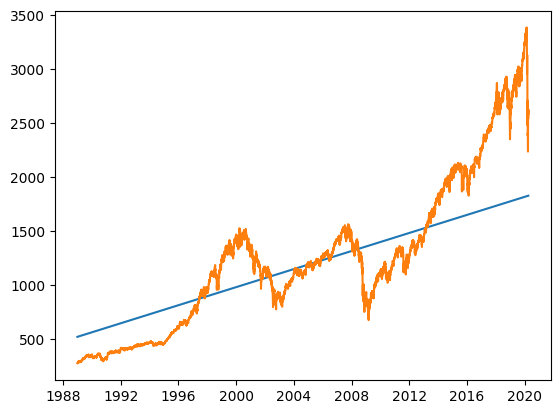

In [32]:
x = np.arange(0,len(df_sp500))
model = LinearRegression().fit(x.reshape((-1, 1)), df_sp500['Sales Per Share'])
y = model.coef_ * x + model.intercept_
plt.plot(df_sp500.index, df_sp500['Price to Sales'].mean() * y)
plt.plot(df_sp500['Price'])

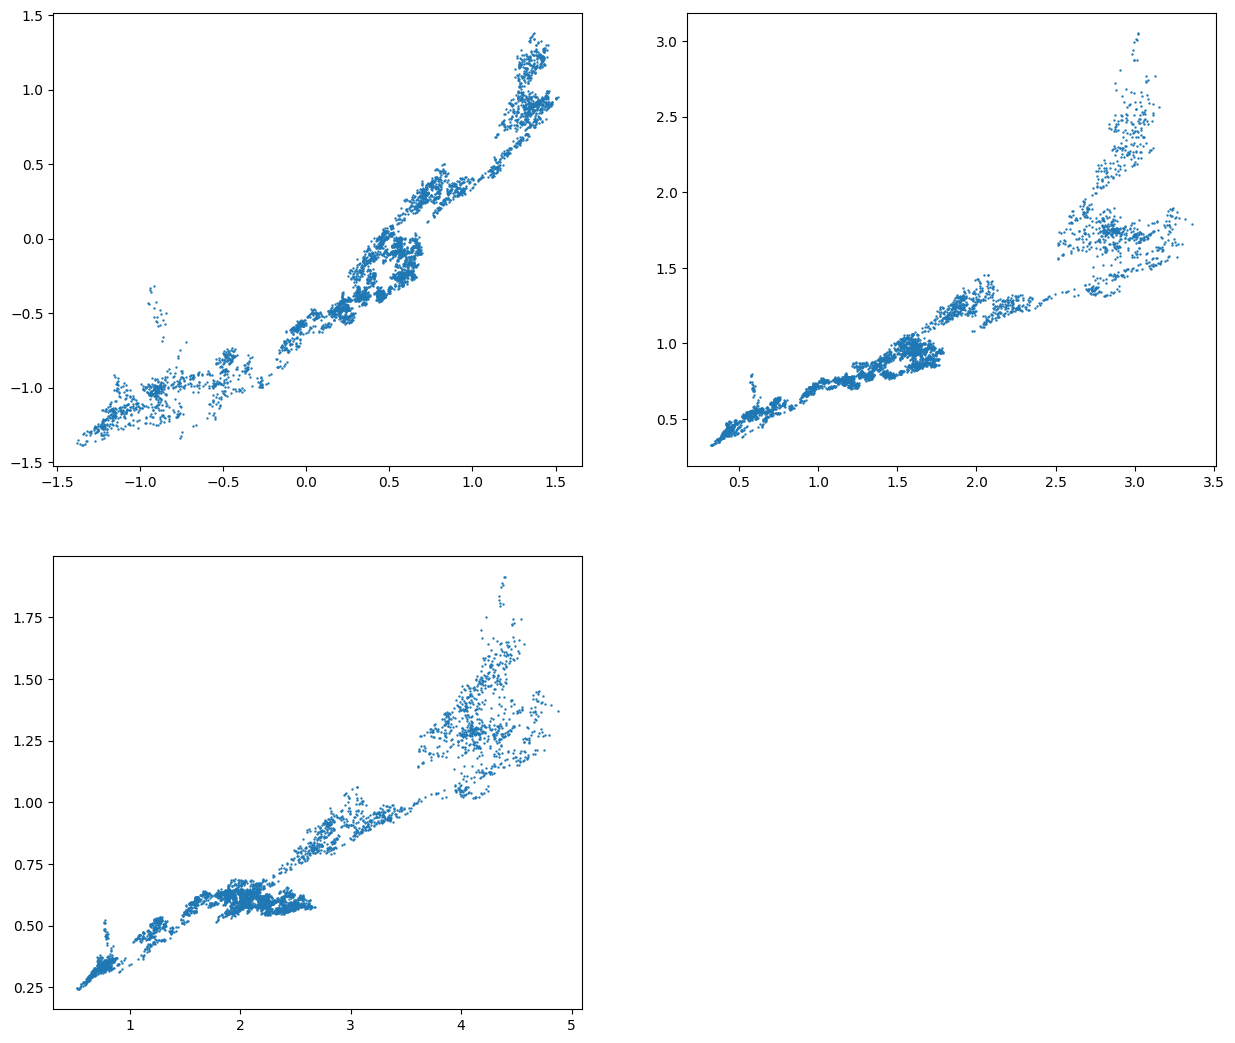

In [7]:
days = 10 * 365
plt.figure(figsize = (15, 20))

plt.subplot(3, 2, 1)
plt.scatter(
    df_sp500['Price to Sales'] - df_sp500['Price to Sales'].shift(days),
    df_sp500['Price to Sales'] - df_sp500['Price to Sales'].shift(-days), s=0.5)

plt.subplot(3, 2, 2)
plt.scatter(
    df_sp500['Price to Sales'] / df_sp500['Price to Sales'].shift(days),
    df_sp500['Price to Sales'] / df_sp500['Price to Sales'].shift(-days), s=0.5)

plt.subplot(3, 2, 3)
plt.scatter(
    df_sp500['Price'] / df_sp500['Price'].shift(days),
    df_sp500['Price'] / df_sp500['Price'].shift(-days), s=0.5)

plt.show()